# Classify and Plot Raster Data

### Manually reclassify raster data

You will learn how to reclassify a raster dataset. When you reclassify a raster, you create a new raster object/file that can be exported and shared with colleagues and/or open in other tools such as QGIS.

In that raster, each pixel is mapped to a new value based on some approach. This approach can vary depending upon your research question

## Raster classification steps

You can break your raster processing workflow into several steps as follows:
- Data import/cleanup: load and "clean" the data. This includes cropping, removing with nodata values
- Data exploration: understand the range and distribution of values in your data. This may involve plotting histograms and scatter plots to determine what classes are appropriate for our data.
- Reclassify the data: Once you understand the distribution of your data, you are ready to reclassify. There are stat and non-stat approaches to reclassification. Here you will learn how to manually reclassify a raster using bins that you define in your data exploration step.

You will be using the LIDAR CHM that was previously calculated

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep
import seaborn as sns

sns.set(font_scale=1.5, style="whitegrid")

et.data.get_data ("colorado-flood")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

In [2]:
os.getcwd()

'C:\\Users\\s1526\\earth-analytics'

In [4]:
os.chdir("C:/Users/s1526/Dropbox/Python_Tutorials/Earth Data Analytics/Python/Intermediate/3. Raster")

chm_path = os.path.join("outputs", "lidar_chm.tif")

with rio.open(chm_path) as src:
    lidar_chm_im = src.read(1, masked=True)

lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-999.99,
  dtype=float32)

### What classification values to Use?

There are many different approaches to classification. Some use highly sophisticated spatial algorithms that identify patterns in the data that can in turn be used to classify particular pixels into particular "classes".

In this caswe, you are simply going to create the classes manually using the range of quantitative values found in our data.

Assuming that our data represent trees (though you know there are likely some buildings in the data), classify your raster into 3 classes:
- Short trees
- Medium trees
- Tall trees

To perform this classification, you need to understand which values represent short trees vs medium trees vs tall trees in your raster. This is where histogram can be extremely useful.

In [5]:
# View the min and max values in the data
print("CHM min value", lidar_chm_im.min())
print("CHM max value", lidar_chm_im.max())

CHM min value 0.0
CHM max value 26.930054


### Get to know raster summary statistics

Get to know your data by looking at a histogram. A histogram quantifies the distribution of values found in your data.

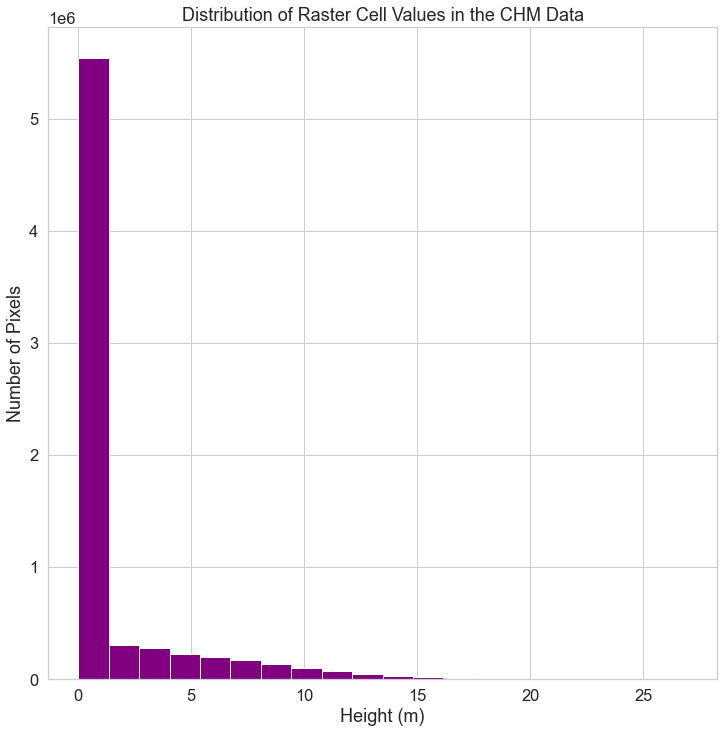

In [6]:
ep.hist(lidar_chm_im.ravel(),
       title="Distribution of Raster Cell Values in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

### Explore raster histograms

Further explore your histogram, by constraining the x axis limits using the xlim and ylim parameters.

These lim parameters visually zooms in on the data in the plot. It does not modify the data.

You might also chose to adjust the number of bins in your plot. Below you plot a bin for each increment on the x axis calculated using:

hist_range(*xlim)

You could also set bins = 100 or some other arbitary number if you wish.

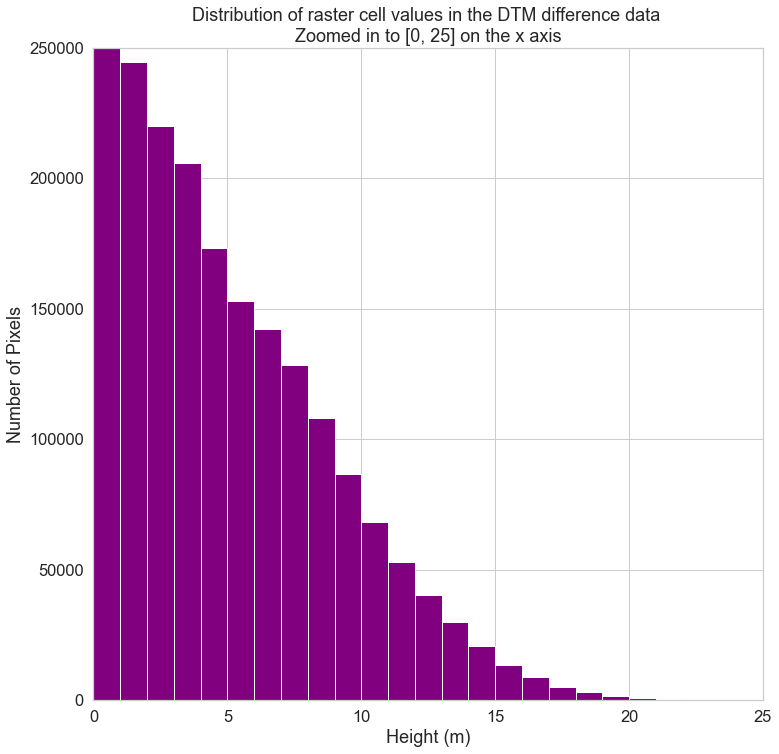

In [7]:
# Create histogram with xlim and ylim
xlim = [0, 25]

f, ax = ep.hist(lidar_chm_im.ravel(),
               hist_range=xlim,
               bins=range(*xlim),
               ylabel="Number of Pixels", xlabel="Height (m)",
               title="Distribution of raster cell values in the DTM difference data \n" + 
               "Zoomed in to {} on the x axis".format(xlim))

ax.set(xlim=xlim, ylim=[0, 250000])

plt.show()

You can look at the values that Python used to draw your histogram, too.

To do this, you can collect the outputs that are returned when you call np.histogram. This consists of 2 things:
- counts, which represents the number of items in each bin
- bins, which represents the edges of the bins (there will be 1 extra item in bins compared to counts)

In [8]:
# Get counts and bins
counts, bins = np.histogram(lidar_chm_im,
                           bins=50,
                           range=xlim)

print("counts:", counts)
print("bins:", bins)

counts: [5292785  155317  128037  116551  109743  110395  107528   98579   89234
   83947   79123   73934   71669   70521   67043   61639   56389   51932
   46193   40674   36442   31877   28428   24553   21620   18613   16095
   13776   11424    9402    7504    6195    4883    3901    2954    2306
    1776    1342    1027     706     525     358     271     160     113
      99      47      44      21      16]
bins: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25. ]


Each bin represents a bar on your histogram plot. Each bar represents the frequency or number of pixels that have a value within that bin.

Notice that you have adjusted the xlim and ylim to zoom into the region of the histogram that you are interested in exploring: however, the values did not actually change.

### Histogram with Custom Breaks

Next, customise your histogram with breaks that you think might make sense as breaks to use for your raster map.

In the example below, breaks are added in 5 m increments using the bins = argument.

bins=[0, 5, 10, 15, 20, 30]

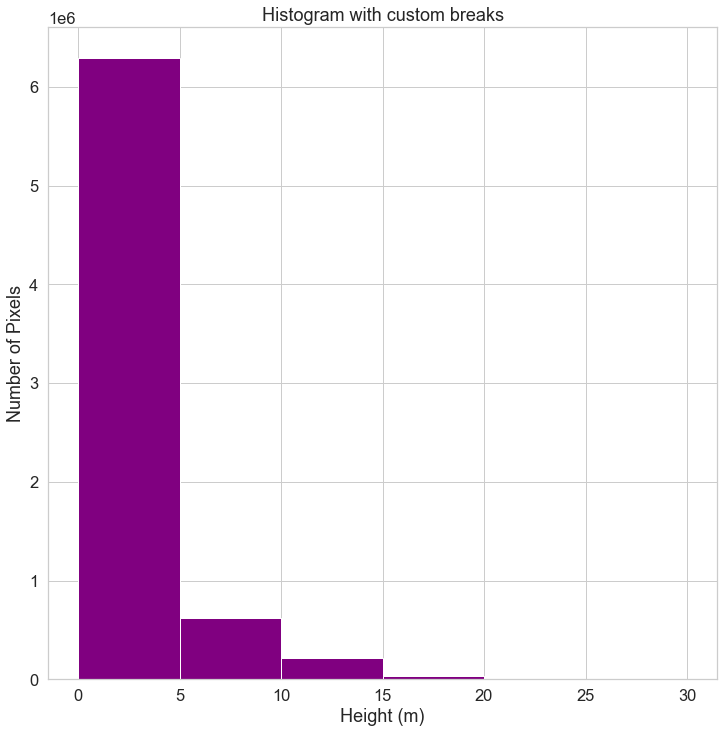

In [9]:
# Histogram with custom breaks
ep.hist(lidar_chm_im.ravel(),
       bins=[0, 5, 10, 15, 20, 30],
       title="Histogram with custom breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

You may want to play with the distribution of breaks. Below it appears as if there are many values close to 0.

In the case of this lidar instrument, you know that values between 0 and 2 m are not reliable.

Below you create a bin between 0-2.

You also know you want to create bins for short, medium and tall trees, so experiment with those bins as well.

Below following breaks are used:
- 0 - 2 = no trees
- 2 - 7 = short trees
- 7 - 12 = medium trees
- > 12 = tall trees

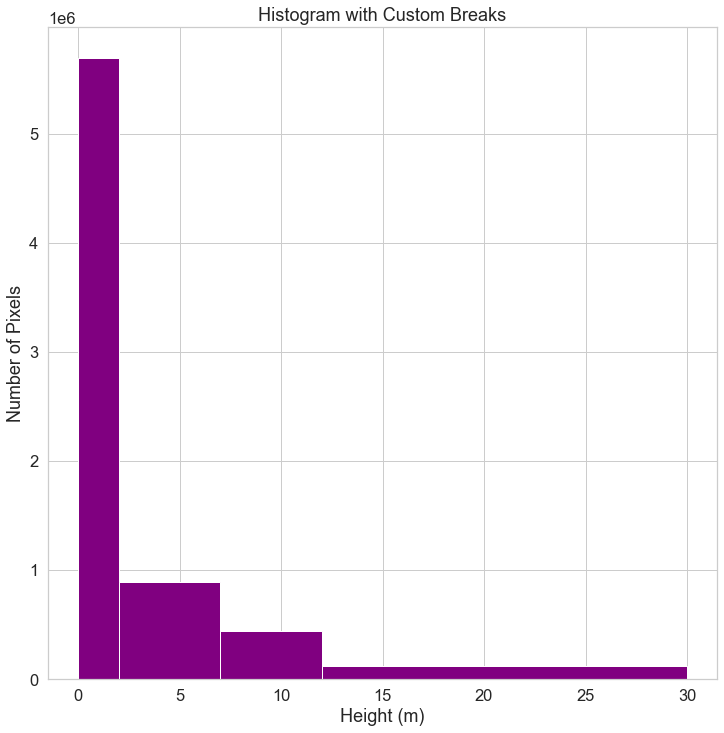

In [10]:
ep.hist(lidar_chm_im.ravel(),
       colors="purple",
       bins=[0, 2, 7, 12, 30],
       title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

## Map raster values to new values

To reclassify your raster, first you need to create a reclassification matrix.

The matrix MAPS a range of values to a new defined value. You will use this matrix to create a classified canopy height model where you designate short, medium, and tall trees.

The newly defined values will be as follows:
- No trees: (0 - 2m tall) = NA
- Short trees: (2 - 7m tall) = 1
- Medium trees: (7 - 12m tall) = 2
- Tall trees: (> 12m tall) = 3

Notice in the list above that you set cells with a value between 0 and 2 m to NA or nodata value. This means you are assuming that there are no trees in those locations!

Notice in the matrix below that you use Inf to represent the largest or max value found in the raster. So our assignmnet is as follows:
- 0 - 2m -> 1
- 2 - 7m -> 2 (short trees)
- 7 - 12m -> 3 (medium trees)
- > 12 or 12 - Inf -> 4 (tall trees)

Below you create the matrix.

np.digitize

Numpy has a function called digitize that is useful for classifying the values in an array. It is similar to how histogram works, because it categorise datapoints into bins. However, unlike histogram, it doesn't aggregate/count the number of values within each bin.

Instead, digitize will replace each datapoint with an integer corresponding to which bin it belongs to. You can use this to determine which datapoints fall within certain ranges.

When you use np.digitize, the bins that you create work as follows:
- The starting value by default is included in each bin. The ending value of the bin is not and will be the beginning of the next bin. You can add the argument right = True if you want to 2nd value in the bin to be included but not the first.
- Any values BELOW the bins as defined will be assigned a 0. Any values ABOVE the highest values in your bins will be assigned to the next value available. Thus, if you have:

class_bins = [0, 2, 7, 12, 30]

Any values that are equal to 30 or larger will be assigned a value of 5. Any values that are < 0 will be assigned a value of 0.

Oftentimes, you can use np.inf in your array to include all values greater than the last value, and you can use -np.inf in your array to include all values less than the 1st value.

However, if you are using the claass bins for a BoundaryNorm object for a plot, np.inf will throw an error in matplotlib. The BoundaryNorm object cannot handle an inf value, so you must supplys it with an actual integer.

A good stand in for np.inf is the max value numpy can store as an integer, which can be accessed by using np.iinfo(np.int32).max. This will have the same effect as np.inf without breaking the BoundaryNorm object.

Likewise, you can use the min value of the array(arr.min()) instead of -np.inf.

In [11]:
# Check fill value for your array
lidar_chm_im.fill_value

-999.99

Below you define 4 bins. However, you end up with a fifth class == 0 which represents values smaller than 0 which is the min value in your chm

These values < 0 come from the numpy mask fill value which you can see identified above this text.

In [13]:
# Define bins that you want, and the classify the data
class_bins = [lidar_chm_im.min(), 2, 7, 12, np.iinfo(np.int32).max]

# Classify the original image array, then unravel it again for plotti9ng
lidar_chm_im_class = np.digitize(lidar_chm_im, class_bins)

# Note that you have an extra class in the data (0)
print(np.unique(lidar_chm_im_class))

[0 1 2 3 4]


In [14]:
type(lidar_chm_im_class)

numpy.ndarray

After running the classification, you have 1 extra class. This class - the first class - is your missing data value. Your classified array output is also a regular (not a masked) array.

You can reassign the 1st class in your data to a mask using np.ma.masked_where().

In [16]:
# Reassign all values that are classified as 0 to masked (no data value)
# This will prevent pixels that == 0 from being rendered on a map in matplotlib
lidar_chm_class_ma = np.ma.masked_where(lidar_chm_im_class == 0,
                                       lidar_chm_im_class,
                                       copy=True)

lidar_chm_class_ma

masked_array(
  data=[[--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        ...,
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=999999,
  dtype=int64)

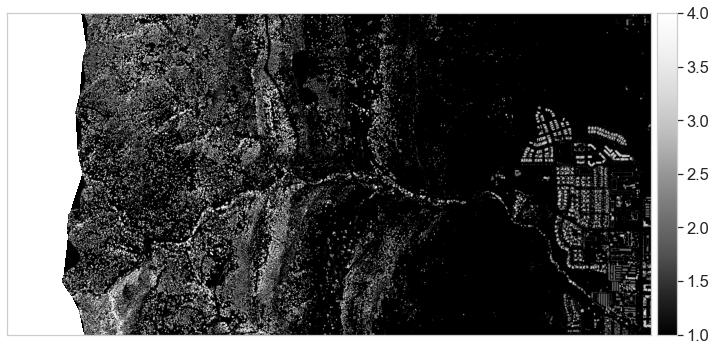

In [17]:
# Plot newly classified and masked raster
ep.plot_bands(lidar_chm_class_ma,
             scale=False)

plt.show()

Below the raster is plotted with slightly improved colors

In [18]:
# Check classes
np.unique(lidar_chm_class_ma)

masked_array(data=[1, 2, 3, 4, --],
             mask=[False, False, False, False,  True],
       fill_value=999999,
            dtype=int64)

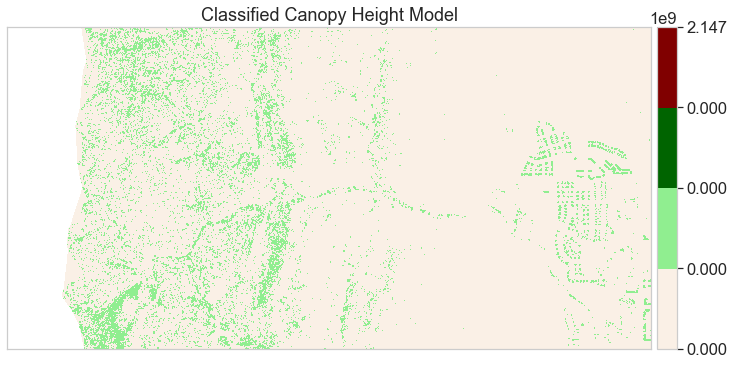

In [21]:
# Plot data using nicer colours
colours = ["linen", "lightgreen", "darkgreen", "maroon"]

cmap = ListedColormap(colours)
norm = BoundaryNorm(class_bins, len(colours))

ep.plot_bands(lidar_chm_class_ma,
             cmap=cmap,
             title="Classified Canopy Height Model",
             scale=False,
             norm=norm)

plt.show()

## Add a custom legend to your plot with Earthpy

The plot looks OK but the legend does not represent the data well. The legend is continuous - with a range between 1.0 and 4.0 However, you want to plot the data using discrete bins.

Given you have discrete values, you can create a custom leegend with the 4 categories that you created in your classification matrix.

There are a few tricky pieces to creating a custom legend.
1. Notice below that you 1st create a list of legend items (or labels):

height_class_labels = ["Short trees", "Less short trees", "Medium trees", "Tall trees"]

This represents the text that will appear in your legend.
1. Next you create the colourmap from a list of colours.

This code: colors = ["linen", "lightgreen", "darkgreen", "maroon"] creates the colour list.

And this code: cmap = ListedColormap(colors) create the colourmap nto be used in the plot code.

In [22]:
# Check classes
np.unique(lidar_chm_class_ma)

masked_array(data=[1, 2, 3, 4, --],
             mask=[False, False, False, False,  True],
       fill_value=999999,
            dtype=int64)

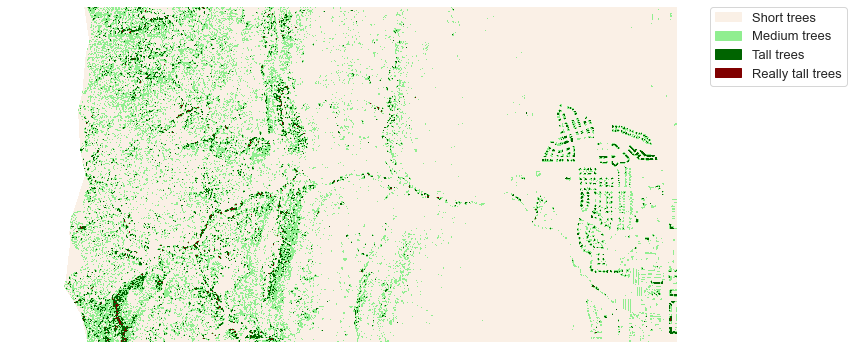

In [23]:
# Check a list of labels to use for your legend
height_class_labels = ["Short trees", "Medium trees", "Tall trees", "Really tall trees"]

# Create a colormap from a list of colors
colours = ["linen", "lightgreen", "darkgreen", "maroon"]
cmap = ListedColormap(colours)

f, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(lidar_chm_class_ma,
              cmap=cmap)

ep.draw_legend(im, titles=height_class_labels)
ax.set_axis_off()

plt.show()